# Image Recognition for Handwritten Digits (MNIST) using CNN in Keras 

* **1. Data preparation**
    * 1.1 Load packages and data
    * 1.2 Check missing values
    * 1.3 Normalization
    * 1.4 Reshape
    * 1.5 Label encoding
    * 1.6 Split training and valdiation set
* **2. CNN**
    * 2.1 Define the model
    * 2.2 Set the optimizer and annealer
    * 2.3 Data augmentation
* **3. Evaluate the model**
    * 3.1 Training and validation curves
    * 3.2 Confusion matrix
* **4. Prediction and submition**
    * 4.1 Make prediction

# 1. Data preparation
## 1.1 Load packages and data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/zengweihao/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

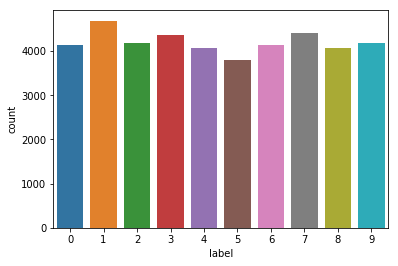

In [5]:
# Store the labels of training data as an object
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# Free some space
del train 

# Check whether the number of digits are balance.
g = sns.countplot(Y_train)
Y_train.value_counts()

We have similar counts for the 10 digits.

## 1.2 Check for missing values

In [6]:
X_train.isnull().any().sum()

0

In [7]:
test.isnull().any().sum()

0

There is no missing values in the train and test dataset. We can go to the next preprocess step.

## 1.3 Normalization

Perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converges faster on [0..1] data than on [0..255].

In [8]:
# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255.0
test /= 255.0

## 1.4 Reshape

In [9]:
# Reshape image with height = 28px, width = 28px , channel = 1
X_train = X_train.values.reshape(-1,28,28,1).astype('float32')
test = test.values.reshape(-1,28,28,1).astype('float32')

Train and test images (28px x 28px) has been stored as 1 dimension series with 784 values. Also, Keras requires an dimension in the end which correspond to channels. For RGB images, there are 3 channels. MNIST images are gray scaled so there is only one channel. Here We reshape the data to so that we can take it as an input of Keras.

## 1.5 Label encoding

In [10]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [11]:
# Encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes = 10)

In [12]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors as the output of Kereas

## 1.6 Split training and valdiation set 

In [13]:
# Set the random seed
random_seed = 1

In [14]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Split the training set in two parts : a small fraction (10%) became the validation set in which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set.

We can get a better sense for one of these examples by visualising the image and looking at the label.

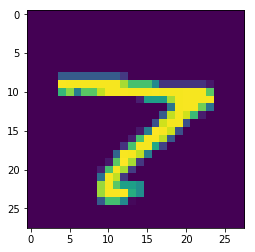

In [15]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 2. CNN
## 2.1 Define the model

The Keras Sequential API is handy because it allows to add one layer at a time, starting from the input.

The first is the convolution (Conv2D) layer. It is like a set of learnable filters. Each filter transforms a part of the image (defined by the kernel size) using the kernel. The kernel matrix is applied on the whole image. You start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time).

Combining convolution and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. It makes the model learn that no feauture is too important and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. It's non-saturating nonlinearities, which is faster to converge but unstable.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolution/maxpool layers. It combines all the found local features of the previous convolution layers.

In the end the two fully-connected (Dense) layers are just artificial neural networks (ANN) classifiers. In the last layer(Dense(10,activation="softmax")) the outputs represent probability of each class.

In [16]:
# Set the CNN model 
# This CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## 2.2 Set the optimizer and annealer

Once the layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

The loss function is to measure how poorly the model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. A specific form for categorical classifications (>2 classes) called the "categorical_crossentropy" is applied in this CNN.

The most important function is the optimizer. This function will iteratively improve parameters (kernel values, weights and bias of neurons ...) in order to minimize the loss. 

RMSprop (with default values), it is a very effective optimizer. The RMSProp adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate, and it is fasteer than Stochastic Gradient Descent ('sgd') optimizer.

The metric function "accuracy" is used is to evaluate the performance our model.

This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [17]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [18]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, I used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. Also if we use a low LR, the optimizer could probably fall into a local minima. However with a high LR, there could be a strong fluctuation in the error function, without a steady decrease.

It's better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. we can reduce the risk of getting stuck in a local minima by adopting a larger learning rate in the beginning and shrinking it over time. This is essentially the principle behind algorithms like Annealer.

To keep the advantage of the fast computation time with a high LR, we decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, we choosed to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [19]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
epochs = 15 # Turn epochs to 30 to get higher accuracy
batch_size = 256

## 2.3 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered, the scale is not the same (some who write with big/small numbers), the image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [21]:
# Without data augmentation I obtained an accuracy ~0.982
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [22]:
# With data augmentation to prevent overfitting (accuracy ~0.995)

aug = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


aug.fit(X_train)

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [23]:
# Fit the model
history = model.fit_generator(aug.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/15
 - 169s - loss: 0.6426 - acc: 0.7930 - val_loss: 0.1092 - val_acc: 0.9702
Epoch 2/15
 - 198s - loss: 0.1905 - acc: 0.9418 - val_loss: 0.0652 - val_acc: 0.9802
Epoch 3/15
 - 197s - loss: 0.1242 - acc: 0.9626 - val_loss: 0.0400 - val_acc: 0.9871
Epoch 4/15
 - 175s - loss: 0.0987 - acc: 0.9703 - val_loss: 0.0424 - val_acc: 0.9850
Epoch 5/15
 - 192s - loss: 0.0784 - acc: 0.9762 - val_loss: 0.0301 - val_acc: 0.9893
Epoch 6/15
 - 170s - loss: 0.0704 - acc: 0.9788 - val_loss: 0.0322 - val_acc: 0.9902
Epoch 7/15
 - 167s - loss: 0.0645 - acc: 0.9818 - val_loss: 0.0307 - val_acc: 0.9905
Epoch 8/15
 - 165s - loss: 0.0561 - acc: 0.9833 - val_loss: 0.0197 - val_acc: 0.9940
Epoch 9/15
 - 165s - loss: 0.0576 - acc: 0.9824 - val_loss: 0.0224 - val_acc: 0.9933
Epoch 10/15
 - 167s - loss: 0.0526 - acc: 0.9848 - val_loss: 0.0313 - val_acc: 0.9919
Epoch 11/15
 - 170s - loss: 0.0497 - acc: 0.9856 - val_loss: 0.0237 - val_acc: 0.9924

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

# 4. Evaluate the model
## 4.1 Training and validation curves

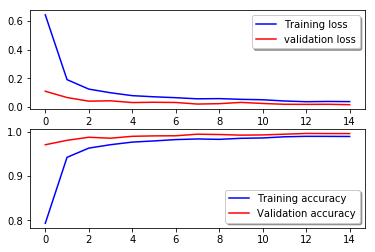

In [24]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The model reaches 99% accuracy on the validation dataset after 6 epochs. The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model dosen't not overfit the training set.

## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

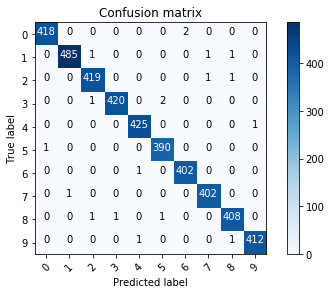

In [25]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

Let's investigate for errors. 

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

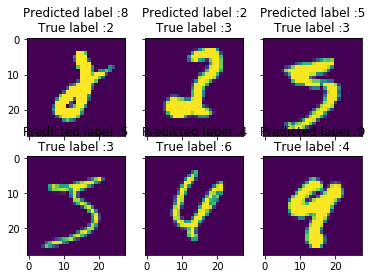

In [26]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intriguing. 

For those six case, the model is not ridiculous. Some of these errors can also be made by humans

In [27]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [28]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist.csv",index=False)

At the end, the model has 0.99557 test accuracy (based on kaggle) using only 15 iterations.

* ** Summary**
     
     This notebook is for gaining experience of implementing deep learning techniques in Python. Most of these works are inspired from the Kaggle community. Through this project I have further understanding about the work flow of building a CNN (by adding layers in sequence one at a time) and perform data augmentation (to handle overfitting) for pattern recognition.
